##**Prerequisites**
* Python 3
*Keras
*TensorFlow
*EfficientNet for TensorFlow Keras
*OpenCV on Wheels
*MTCNN

In [1]:
!pip install -r /content/drive/MyDrive/MLCV/hw3_summer/requirements.txt >/dev/null 2>&1

##**1. Convert video frames to individual images and extract faces from the frames with MTCNN**

In [2]:
import json
import os
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import sys, os.path
from keras import backend as K
import tensorflow as tf

In [3]:
def get_filename_only(file_path):
  '''
  This function extracts the filename without the extension from a given file path,
  allowing for clean directory names and consistent naming of extracted frame files.
  '''
  file_basename = os.path.basename(file_path)
  filename_only = file_basename.split('.')[0]
  return filename_only

In [4]:
def read_metadata(path):
  with open(os.path.join(path, 'metadata.json')) as metadata_json:
    metadata = json.load(metadata_json)
    print("Number of videos:",len(metadata))
  return metadata

In [5]:
BASE_PATH = '/content/drive/MyDrive/MLCV/hw3_summer/'
VIDEOS_PATH = BASE_PATH + 'train_sample_videos'

In [6]:
metadata = read_metadata(VIDEOS_PATH)
true_labels = pd.DataFrame.from_dict(metadata, orient='index', dtype="category").reset_index().rename(columns={'index': 'video'}).drop(['split','original'], axis=1)

Number of videos: 400


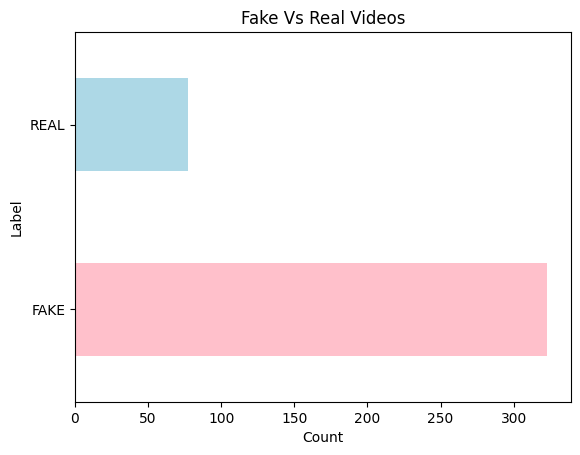

In [7]:
label_counts = true_labels['label'].value_counts()
label_counts.plot(kind='barh', color=['pink', 'lightblue'])
plt.title('Fake Vs Real Videos')
plt.xlabel('Count')
plt.ylabel('Label')
plt.show()

In [8]:
def create_directory(path):
  print('Creating Directory: ' + path)
  os.makedirs(path, exist_ok=True)

In [9]:
def open_video(path, filename):
  video_file = os.path.join(path, filename)
  cap = cv2.VideoCapture(video_file)
  frame_rate = cap.get(5) # Frame rate
  return cap, frame_rate

In [10]:
def should_process_frame(frame_id, frame_rate):
    """
    Determines if the current frame should be processed.
    """
    return frame_id % math.floor(frame_rate) == 0

**Why is `should_process_frame()` needed?**

Videos typically have a high frame rate, often 24, 30, or even more frames per second (FPS). Processing and saving every single frame might not be necessary and could lead to a large number of image files, which might be inefficient in terms of storage and processing time.

In [11]:
def calculate_scale_ratio(frame_width):
    if frame_width < 300:
        return 2
    elif frame_width > 1900:
        return 0.33
    elif frame_width > 1000 and frame_width <= 1900:
        return 0.5

    return 1

In [12]:
def resize_frame(frame, scale_ratio):
    width = int(frame.shape[1] * scale_ratio)
    height = int(frame.shape[0] * scale_ratio)
    dim = (width, height)
    new_frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
    return new_frame

In [13]:
def process_each_face(results, image, faces_path, frame, count):
  for result in results:
    bounding_box = result['box']
    #print('Bounding Box:',bounding_box)
    confidence = result['confidence']
    #print('Confidence:',confidence)

    if single_face_or_high_confidence(results, confidence):
      new_bounding_box = calculate_bounding_box_with_margin(bounding_box, image)
      crop_and_save_face(image, new_bounding_box, os.path.join(faces_path, get_filename_only(frame)), count)
      count = count + 1
    else:
      print('Skipped a face due to low confidence...')
  return count

In [14]:
def extract_faces_from_image(frame, save_path, filename, count):
  """
  Detect and save faces from a single frame image.
  """
  results, image = detect_faces_in_image(frame)

  count = process_each_face(results, image, save_path, filename, count)

  return count

In [15]:
def detect_faces_in_image(frame):
  detector = MTCNN()
  rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  return detector.detect_faces(rgb_image), rgb_image

In [16]:
def video_to_frames(path,filename, label, real_path, fake_path):
  print('Converting Video to Images...')
  cap, frame_rate = open_video(path, filename)
  count = 0

  save_path = real_path if label == 'REAL' else fake_path

  while(cap.isOpened()):
    frame_id = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if should_process_frame(frame_id, frame_rate):
      #print('Original Dimensions: ', frame.shape)
      scale_ratio = calculate_scale_ratio(frame.shape[1])
      #print('Scale Ratio: ', scale_ratio)
      resized_frame = resize_frame(frame, scale_ratio)
      #print('Resized Dimensions: ', resized_frame.shape)

      count = extract_faces_from_image(resized_frame, save_path, filename, count)


  cap.release()
  print("Done!")


In [17]:
def get_frame_images(path):
  """
  Retrieves a list of image filenames from the temporary directory.
  """
  return [x for x in os.listdir(path) if os.path.isfile(os.path.join(path, x))]

In [18]:
def crop_and_save_face(image, bounding_box, save_path, count):
  x1, y1, x2, y2 = bounding_box
  #print('Cropping face with coordinates: (',x1, y1, x2, y2,')')
  crop_image = image[y1:y2, x1:x2]
  new_filename = '{}-{:02d}.png'.format(save_path, count)
  cv2.imwrite(new_filename, cv2.cvtColor(crop_image, cv2.COLOR_RGB2BGR))

In [19]:
def calculate_bounding_box_with_margin(bounding_box, image, margin_percentage=0.3):
  margin_x = bounding_box[2] * margin_percentage
  margin_y = bounding_box[3] * margin_percentage
  x1 = max(int(bounding_box[0] - margin_x), 0)
  x2 = min(int(bounding_box[0] + bounding_box[2] + margin_x), image.shape[1])
  y1 = max(int(bounding_box[1] - margin_y), 0)
  y2 = min(int(bounding_box[1] + bounding_box[3] + margin_y), image.shape[0])
  #print(x1, y1, x2, y2)
  return (x1, y1, x2, y2)

In [20]:
def single_face_or_high_confidence(faces, confidence):
  return len(faces) < 2 or confidence > 0.95

In [21]:
DATASET_PATH = BASE_PATH + 'prepared_dataset/'
REAL_PATH = DATASET_PATH + 'real'
FAKE_PATH = DATASET_PATH + 'fake'

create_directory(DATASET_PATH)
create_directory(REAL_PATH)
create_directory(FAKE_PATH)

Creating Directory: /content/drive/MyDrive/MLCV/hw3_summer/prepared_dataset/
Creating Directory: /content/drive/MyDrive/MLCV/hw3_summer/prepared_dataset/real
Creating Directory: /content/drive/MyDrive/MLCV/hw3_summer/prepared_dataset/fake


In [ ]:
for filename in metadata.keys():
    print(filename)
    # Suppress output
    with open(os.devnull, 'w') as devnull:
      old_stdout = sys.stdout
      sys.stdout = devnull

      if (filename.endswith(".mp4")):
        video_to_frames(VIDEOS_PATH, filename,metadata[filename]['label'], REAL_PATH, FAKE_PATH)
      else:
        continue

      # Restore output
      sys.stdout = old_stdout



##**2. Balance and split datasets into various folders**

In [22]:
from distutils.dir_util import copy_tree
import shutil
import numpy as np
import splitfolders

In [24]:
def downsample_fake_faces(real_path, tmp_fake_path, fake_path):
  """Downsample fake faces to match the number of real faces."""
  all_real_faces = [f for f in os.listdir(real_path) if os.path.isfile(os.path.join(real_path, f))]
  print('Total Number of Real faces: ', len(all_real_faces))

  all_fake_faces = [f for f in os.listdir(tmp_fake_path) if os.path.isfile(os.path.join(tmp_fake_path, f))]
  print('Total Number of Fake faces: ', len(all_fake_faces))

  random_faces = np.random.choice(all_fake_faces, len(all_real_faces), replace=False)
  for fname in random_faces:
      src = os.path.join(tmp_fake_path, fname)
      dst = os.path.join(fake_path, fname)
      shutil.copyfile(src, dst)

  shutil.rmtree(tmp_fake_path)
  os.rename(fake_path, tmp_fake_path)
  print('Down-sampling Done!')

In [25]:
def split_dataset(dataset_path, base_path):
  """Split dataset into Train/Val/Test folders."""
  splitfolders.ratio(dataset_path, output= BASE_PATH + '/split_dataset', seed=1377, ratio=(.8, .1, .1))
  print('Train/ Val/ Test Split Done!')

In [ ]:
FAKE_DOWNSAMPLED_PATH = DATASET_PATH + 'fake_downsampled'
create_directory(FAKE_DOWNSAMPLED_PATH)

downsample_fake_faces(REAL_PATH, FAKE_PATH, FAKE_DOWNSAMPLED_PATH)
split_dataset(DATASET_PATH, BASE_PATH)



Copying files: 0 files [00:00, ? files/s]

Copying files: 1 files [00:00,  4.46 files/s]

Copying files: 7 files [00:00, 25.03 files/s]

Copying files: 11 files [00:03,  2.43 files/s]

Copying files: 13 files [00:05,  1.75 files/s]

Copying files: 21 files [00:05,  4.09 files/s]

Copying files: 26 files [00:06,  5.97 files/s]

Copying files: 33 files [00:06,  9.46 files/s]

Copying files: 39 files [00:06, 13.02 files/s]

Copying files: 46 files [00:06, 18.21 files/s]

Copying files: 52 files [00:06, 22.48 files/s]

Copying files: 59 files [00:06, 28.61 files/s]

Copying files: 65 files [00:06, 33.31 files/s]

Copying files: 71 files [00:06, 35.72 files/s]

Copying files: 77 files [00:06, 39.20 files/s]

Copying files: 83 files [00:07, 43.00 files/s]

Copying files: 89 files [00:07, 45.11 files/s]

Copying files: 96 files [00:07, 49.92 files/s]

Copying files: 102 files [00:07, 47.21 files/s]

Copying files: 108 files [00:07, 47.68 files/s]

Copying files: 115 files [00:07, 51.29 file

Train/ Val/ Test Split Done!


##**3. Model training**

In [26]:
from distutils.dir_util import copy_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [27]:
def setup_data_generators(dataset_path, input_size, batch_size_num):
  train_path = os.path.join(dataset_path, 'train')
  val_path = os.path.join(dataset_path, 'val')
  test_path = os.path.join(dataset_path, 'test')

  train_datagen = ImageDataGenerator(
      rescale = 1/255,
      rotation_range = 10,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      shear_range = 0.2,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      directory = train_path,
      target_size = (input_size, input_size),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = batch_size_num,
      shuffle = True
  )

  val_datagen = ImageDataGenerator(rescale = 1/255)#rescale the tensor values to [0,1]

  val_generator = val_datagen.flow_from_directory(
      directory = val_path,
      target_size = (input_size, input_size),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = batch_size_num,
      shuffle = True
  )

  test_datagen = ImageDataGenerator(rescale = 1/255) #rescale the tensor values to [0,1]

  test_generator = test_datagen.flow_from_directory(
      directory = test_path,
      classes=['real', 'fake'],
      target_size = (input_size, input_size),
      color_mode = "rgb",
      class_mode = None,
      batch_size = 1,
      shuffle = False
  )

  return train_generator, val_generator, test_generator

In [28]:
# Build the CNN model using EfficientNetB0
def build_model(input_size):
  efficient_net = EfficientNetB0(
      weights = 'imagenet',
      input_shape = (input_size, input_size, 3),
      include_top = False,
      pooling = 'max'
  )

  model = Sequential()
  model.add(efficient_net)
  model.add(Dense(units = 512, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 128, activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  model.summary()
  return model

In [29]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D, Input

def build_model(input_size):
    # Define the input tensor
    input_tensor = Input(shape=(input_size, input_size, 3))

    # Load the EfficientNetB0 model with the input tensor
    efficient_net = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor
    )

    # Add a GlobalMaxPooling2D layer
    x = GlobalMaxPooling2D()(efficient_net.output)

    # Add dense layers
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=128, activation='relu')(x)
    output_tensor = Dense(units=1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # Print the model summary
    model.summary()

    return model

In [30]:
def compile_model(model):
  model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
def setup_callbacks(checkpoint_filepath):
  create_directory(checkpoint_filepath)

  custom_callbacks = [
      EarlyStopping(
          monitor = 'val_loss',
          mode = 'min',
          patience = 5,
          verbose = 1
      ),
      ModelCheckpoint(
          filepath = os.path.join(checkpoint_filepath, 'best_model.keras'),
          monitor = 'val_loss',
          mode = 'min',
          verbose = 1,
          save_best_only = True
      )
  ]

  return custom_callbacks

In [32]:
def plot_training_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.show()

In [33]:
def train_model(model, train_generator, val_generator, custom_callbacks, num_epochs=20):

  history = model.fit(
      train_generator,
      epochs = num_epochs,
      steps_per_epoch = len(train_generator),
      validation_data = val_generator,
      callbacks = custom_callbacks
  )
  print(history.history)
  plot_training_history(history)
  return history

In [34]:
def averaging(test_results):
    """
    Averaging frame predictions per video
    """
    # Group by VideoName and average predictions for each video
    video_predictions = test_results.groupby('VideoName')['Prediction'].mean().reset_index()

    # Assign a label based on the averaged prediction
    video_predictions['PredLabel'] = video_predictions['Prediction'].apply(lambda x: 'REAL' if x < 0.5 else 'FAKE')

    print(video_predictions)
    return video_predictions

def max_prediction(test_results):
    """
    Max prediction per video
    """
    # Group by VideoName and get the maximum prediction for each video
    video_predictions = test_results.groupby('VideoName')['Prediction'].max().reset_index()
    # Assign a label based on the maximum prediction
    video_predictions['PredLabel'] = video_predictions['Prediction'].apply(lambda x: 'REAL' if x < 0.5 else 'FAKE')

    print(video_predictions)
    return video_predictions

def majority_voting(test_results):
    """
    Majority voting for video classification
    """
    # Assign binary labels for each frame based on the threshold
    test_results['FrameLabel'] = test_results['Prediction'].apply(lambda x: 1 if x >= 0.5 else 0)

    # Group by VideoName and get the mean of frame labels (majority voting)
    video_predictions = test_results.groupby('VideoName')['FrameLabel'].mean().reset_index()
    # If more than half the frames are labeled as fake (1), label the video as 'FAKE'
    video_predictions['PredLabel'] = video_predictions['FrameLabel'].apply(lambda x: 'FAKE' if x > 0.5 else 'REAL')

    print(video_predictions)
    return video_predictions

In [35]:
def load_and_predict(checkpoint_filepath, test_generator):
  best_model = load_model(os.path.join(checkpoint_filepath, 'best_model.keras'))

  test_generator.reset()

  preds = best_model.predict(
      test_generator,
      verbose = 1
  )

  test_results = pd.DataFrame({
      "Filename": test_generator.filenames,
      "Prediction": preds.flatten()
  })

  #Extract video names from frame file names and aggregate predictions
  test_results['VideoName'] = test_results['Filename'].apply(lambda x: x.split('-')[0])

  #Strategy-1
  video_predictions = averaging(test_results)
  #Strategy-2
  #video_predictions = max_prediction(test_results)
  #Strategy-3
  #video_predictions = majority_voting(test_results)

  return video_predictions

In [36]:
# set parameters
DATASET_PATH = BASE_PATH + 'split_dataset'
TMP_DEBUG_PATH = BASE_PATH + 'tmp_debug'
CHECKPOINT_FILEPATH = BASE_PATH + 'tmp_checkpoint'
input_size = 128
batch_size_num = 32

In [37]:
train_generator, val_generator, test_generator = setup_data_generators(DATASET_PATH, input_size, batch_size_num)

Found 1440 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [ ]:
model = build_model(input_size)
compile_model(model)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,771,236 (18.20 MB)

 Trainable params: 4,729,213 (18.04 MB)

 Non-trainable params: 42,023 (164.16 KB)

Creating Directory: /content/drive/MyDrive/MLCV/hw3_summer/tmp_checkpoint
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5135 - loss: 1.3184
Epoch 1: val_loss improved from inf to 0.92499, saving model to /content/drive/MyDrive/MLCV/hw3_summer/tmp_checkpoint/best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 466s 8s/step - accuracy: 0.5142 - loss: 1.3137 - val_accuracy: 0.5000 - val_loss: 0.9250
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.92499 to 0.92499, saving model to /content/drive/MyDrive/MLCV/hw3_summer/tmp_checkpoint/best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9250
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6206 - loss: 0.8193
Epoch 3: val_loss improved from 0.92499 to 0.86013, saving model to /content/drive/MyDrive/MLCV/hw3_summer/tmp_checkpoint/best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6203 - loss: 0.8190 - val_accuracy: 0.5000 - val_loss: 0.8601
Epoch 4/20

Epoch 4: val_loss did not improve from 0.86013
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.8601
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6485 - loss: 0.6560
Epoch 5: val_loss improved from 0.86013 to 0.74224, saving model to /content/drive/MyDrive/MLCV/hw3_summer/tmp_checkpoint/best_mode

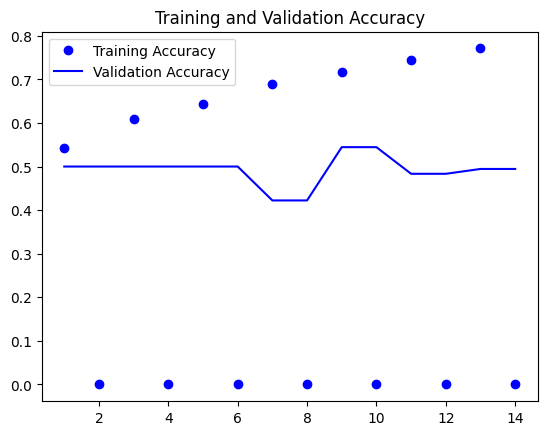

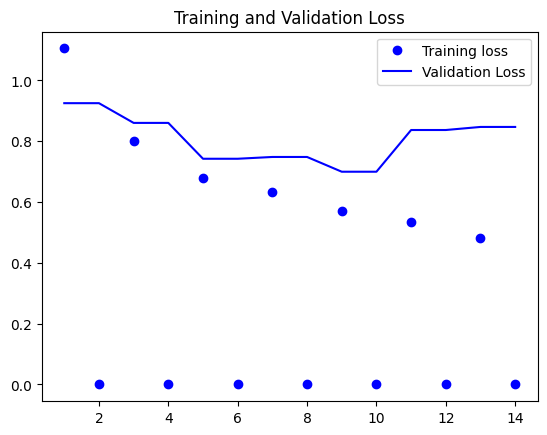

In [ ]:
custom_callbacks = setup_callbacks(CHECKPOINT_FILEPATH)
history = train_model(model, train_generator, val_generator, custom_callbacks)

In [54]:
test_results = load_and_predict(CHECKPOINT_FILEPATH, test_generator)

182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step
           VideoName    Prediction PredLabel
0    fake/abqwwspghj  0.000000e+00      REAL
1    fake/ahdbuwqxit  5.599016e-31      REAL
2    fake/akzbnazxtz  0.000000e+00      REAL
3    fake/altziddtxi  1.000000e+00      FAKE
4    fake/alvgwypubw  1.000000e+00      FAKE
..               ...           ...       ...
120  real/edyncaijwx  1.151806e-28      REAL
121  real/efwfxwwlbw  5.000000e-01      FAKE
122  real/eggbjzxnmg  7.500000e-01      FAKE
123  real/egghxjjmfg  1.000000e+00      FAKE
124  real/ehccixxzoe  5.000000e-01      FAKE

[125 rows x 3 columns]


## **4. Evaluation**

In [55]:
test_results['VideoName'] = test_results['VideoName'].str.split('/').str[1]
true_labels['VideoName'] = true_labels['video'].str.split('.').str[0]
test_results = pd.merge(test_results, true_labels, on='VideoName', how='left').rename(columns={'label': 'TrueLabel'}).drop(columns=['video'])

test_results

,VideoName,Prediction,PredLabel,TrueLabel
0,abqwwspghj,0.000000e+00,REAL,FAKE
1,ahdbuwqxit,5.599016e-31,REAL,FAKE
2,akzbnazxtz,0.000000e+00,REAL,FAKE
3,altziddtxi,1.000000e+00,FAKE,FAKE
4,alvgwypubw,1.000000e+00,FAKE,FAKE
...,...,...,...,...
120,edyncaijwx,1.151806e-28,REAL,REAL
121,efwfxwwlbw,5.000000e-01,FAKE,REAL
122,eggbjzxnmg,7.500000e-01,FAKE,REAL
123,egghxjjmfg,1.000000e+00,FAKE,REAL


In [51]:
print("REAL videos in test set:",test_results[test_results['TrueLabel']== 'REAL'].shape[0])
print("FAKE videos in test set:",test_results[test_results['TrueLabel']== 'FAKE'].shape[0])

REAL videos in test set: 52
FAKE videos in test set: 73


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test,y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy:',accuracy.round(2))

  precision = precision_score(y_test, y_pred, pos_label='FAKE',zero_division=0)
  print('Precision:',precision.round(2))

  recall = recall_score(y_test, y_pred, pos_label='FAKE')
  print('Recall:',recall.round(2))

  f1 = f1_score(y_test, y_pred, pos_label='FAKE')
  print('F1:',f1.round(2))

In [56]:
y_true = test_results['TrueLabel']
y_pred = test_results['PredLabel']
evaluate_model(y_true,y_pred)

Accuracy: 0.48
Precision: 0.55
Recall: 0.64
F1: 0.59


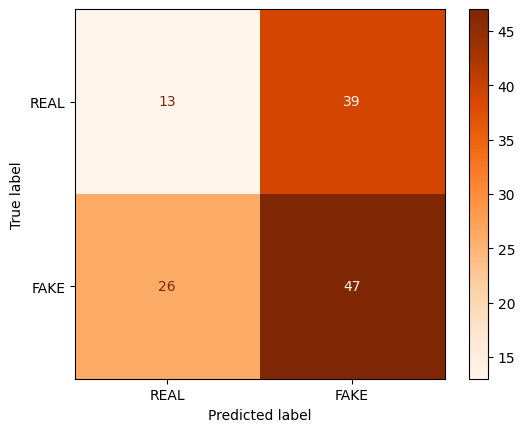

In [57]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=['REAL','FAKE'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['REAL','FAKE'])
disp.plot(cmap='Oranges')
plt.show()